In [91]:
#Import essential libraries
import matplotlib.pyplot as plt
import numpy as np
import typy
#Paralel computing 
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()-2

In [92]:
#Data folder
work_dir = "/work/bansil/s.sevim/0_NbSe2_Work/0.00565"
outfolder="results_GMKG_1001"

In [93]:
#Define data size
nk = 256*256
nq = 1002
q_path = np.arange(nq)
nph = 9

In [94]:
#Fermi energy and convergance parameter
ef = 1.126000
delta=0.0000001

In [95]:
epw = typy.epw(work_dir,outfolder,nk,nq,nph)

In [96]:
ph = epw.ph
g_abs = epw.g_abs
g_complex = epw.g_complex
e_k = epw.e_k
e_kq = epw.e_kq

In [97]:
#Band symmetry points
sym, path = typy.path_create(1001,np.array([[0.0,0.0,0.0],[0.0,0.5,0.0],[1/3,1/3,0],[0.0,0.0,0.0]]))

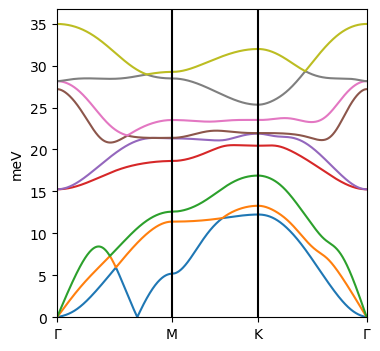

In [98]:
#Untangled band
fig = plt.figure(figsize=(4,4))
for i in range(nph):
    plt.plot(ph[i],label=i)
plt.xlim(0,nq)
plt.ylim(0)
plt.xticks(sym,["Γ","M","K","Γ"])
for i in sym[1:-1]:
    plt.axvline(i,c='black')
plt.ylabel(r"meV")
# plt.title(r"$\Omega$")
plt.show()

In [49]:
ph_xs =typy.ph_cross(ph,tolerance=0.13)
temp_ph = typy.untangle(ph,ph_xs)

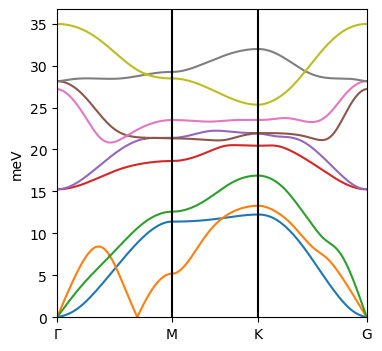

In [50]:
#Untangled band
fig = plt.figure(figsize=(4,4))
for i in range(nph):
    plt.plot(temp_ph[i],label=i)
plt.xlim(0,nq)
plt.ylim(0)
plt.xticks(sym,["Γ","M","K","G"])
for i in sym[1:-1]:
    plt.axvline(i,c='black')
plt.ylabel(r"meV")
# plt.legend()
# plt.title(r"$\Omega$")
plt.show()

In [51]:
temp_g_complex = typy.untangle(g_complex,ph_xs)

In [52]:
temp_g_complex_mean = (temp_g_complex*temp_g_complex.conj()).mean(axis=2)

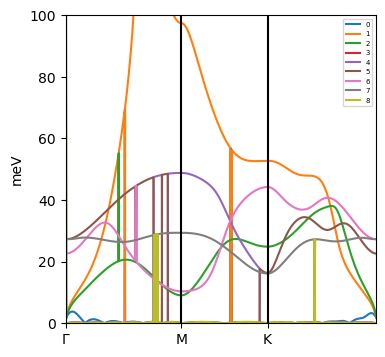

In [53]:
sq = np.sqrt(temp_g_complex_mean.real)
fig = plt.figure(figsize=(4,4))
for i in range(0,9):
    plt.plot(sq[i],label=i)
plt.xlim(0,nq)
plt.ylabel(r"meV")
plt.xticks(sym,["Γ","M","K","G"])
for i in sym[1:-1]:
    plt.axvline(i,c='black')
plt.ylim(0,100)
plt.legend(fontsize=5)
plt.xlim(0,nq-3)
plt.show()

In [54]:
g_xs = typy.g_cross(sq,tolerance = 10,offset=50)

In [55]:
temp_g_complex_mean = typy.untangle(sq,g_xs)

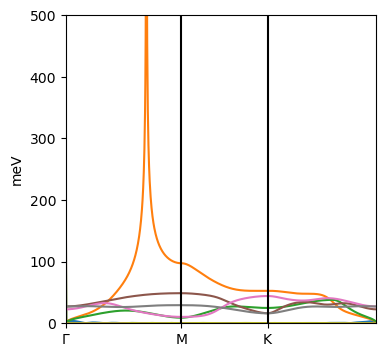

In [56]:
fig = plt.figure(figsize=(4,4))
for i in range(9):
    plt.plot(temp_g_complex_mean[i],label=i)
plt.xlim(0,nq)
plt.ylabel(r"meV")
plt.xticks(sym,["Γ","M","K","Γ"])
for i in sym[1:-1]:
    plt.axvline(i,c='black')
# plt.legend()
plt.ylim(0,500)
plt.xlim(0,nq-3)
plt.show()

In [57]:
fixed_ph = typy.untangle(temp_ph,g_xs)

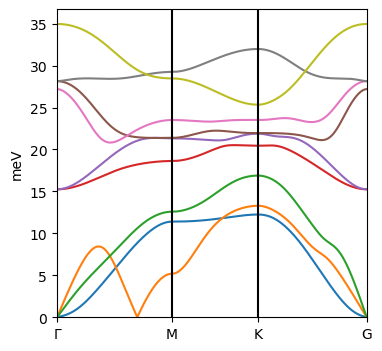

In [58]:
#Untangled band
fig = plt.figure(figsize=(4,4))
for i in range(nph):
    plt.plot(fixed_ph[i],label=i)
plt.xlim(0,nq)
plt.ylim(0)
plt.xticks(sym,["Γ","M","K","G"])
for i in sym[1:-1]:
    plt.axvline(i,c='black')
plt.ylabel(r"meV")
# plt.title(r"$\Omega$")
plt.show()

In [59]:
temp_g_complex  = typy.untangle(g_complex,ph_xs)
fixed_g_complex = typy.untangle(temp_g_complex,g_xs)

In [60]:
reduced_fixed_g_complex = fixed_g_complex.copy()
for i in range(nph):
    for j in range(nq):
        reduced_fixed_g_complex[i][j]*=np.sqrt(fixed_ph[i][j])

In [61]:
reduced_fixed_g_complex_mean = (reduced_fixed_g_complex*reduced_fixed_g_complex.conj()).mean(axis=2)

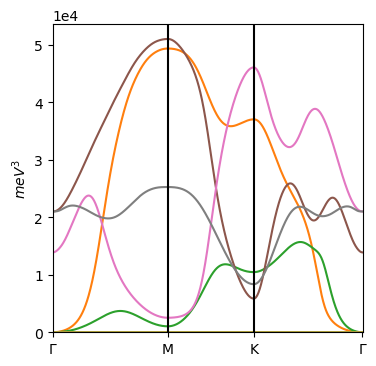

In [62]:
fig = plt.figure(figsize=(4,4))
for i in range(nph):
    plt.plot(reduced_fixed_g_complex_mean[i].real,label=i)
plt.xlim(0,nq)
plt.ylim(0)
plt.ylabel(r"${meV}^{3}$")
plt.xticks(sym,["Γ","M","K","Γ"])
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# plt.savefig("./output/G.jpg",bbox_inches='tight')
for i in sym[1:-1]:
    plt.axvline(i,c='black')
# plt.legend()
plt.show()

In [63]:
class susceptibility:
    def __init__(self, e_k,e_kq,ef,delta,phonon=False):
        self.e_k = e_k
        self.e_kq = e_kq
        self.ef = ef
        self.delta = delta
        self.nk = e_k.shape[1]
        if (phonon):
            self.ph = phonon*10**-3
            self.nq = len(phonon)
    def calculate(self,q):
        temp_sum=0
        for k in range(self.nk):
            temp_sum+= (typy.fd(self.e_k[q][k]-self.ef)-typy.fd(self.e_kq[q][k]-self.ef))/(self.e_k[q][k]-self.e_kq[q][k]+1j*self.delta)
        return  -temp_sum/nk*10**-3
    def factor(self,q):
        temp_sum=0
        k_array = np.zeros(self.nk, dtype=complex)
        for k in range(self.nk):
            k_array[k] = (typy.fd(self.e_k[q][k]-self.ef)-typy.fd(self.e_kq[q][k]-self.ef))/(self.e_k[q][k]-self.e_kq[q][k]+1j*self.delta)
        return  -k_array*10**-3
    def adiabatic_factor(self,q):
            temp_sum=0
            k_array = np.zeros(shape=(self.nq,self.nk), dtype=complex)
            for i in range(self.nq):
                for k in range(self.nk):
                    k_array[i][k] = (typy.fd(self.e_k[q][k]-self.ef)-typy.fd(self.e_kq[q][k]-self.ef))/(self.e_k[q][k]-self.e_kq[q][k]+1j*self.delta+self.ph[i][q])
            return  -k_array*10**-3

In [64]:
prep_suscep = susceptibility(e_k,e_kq,ef,delta)

In [65]:
%%time
suscep_results = Parallel(n_jobs=num_cores)(delayed(prep_suscep.calculate)(i) for i in range(nq))

CPU times: user 1.2 s, sys: 11.3 s, total: 12.5 s
Wall time: 35.1 s


In [66]:
%%time
factor_results = Parallel(n_jobs=num_cores)(delayed(prep_suscep.factor)(i) for i in range(nq))

CPU times: user 1.49 s, sys: 1.11 s, total: 2.6 s
Wall time: 21 s


In [67]:
suscep_val = np.array(suscep_results).real

In [68]:
from scipy.ndimage import gaussian_filter1d

In [69]:
filtered_suscep = gaussian_filter1d(suscep_val.astype("float32"),10)

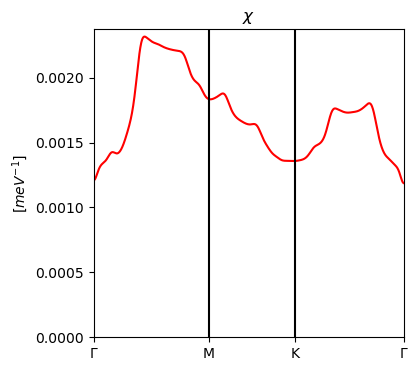

In [90]:
fig = plt.figure(figsize=(4,4))
plt.plot(filtered_suscep,c='r')
plt.xlim(0,nq)
plt.ylim(0)
plt.xticks(sym,["Γ","M","K","Γ"])
plt.ylabel(r"[$meV^{-1}$]")
plt.title(r"$\chi$")
for i in sym[1:-1]:
    plt.axvline(i,c='black')
# plt.savefig("./output/X.jpg",bbox_inches='tight')

# plt.savefig("./output/chi.jpg",bbox_inches='tight')
plt.show()

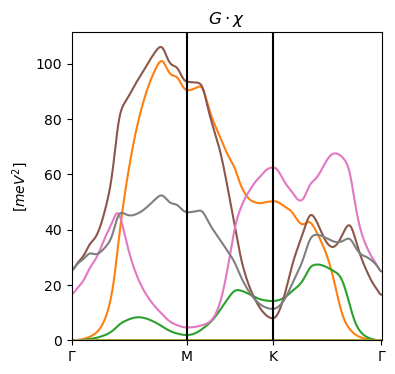

In [71]:
fig = plt.figure(figsize=(4,4))
for i in range(nph):
    plt.plot(filtered_suscep*reduced_fixed_g_complex_mean[i].real)

plt.title(r"$G\cdot \chi$")
    # plt.plot(g_abs_mean[i]/g_abs_mean.max(),c='blue')
plt.xlim(0,nq)
plt.ylim(0)
for i in sym[1:-1]:
    plt.axvline(i,c='black')
plt.ylabel(r"$[{meV}^{2}]$")
plt.xticks(sym,["Γ","M","K","Γ"])
# plt.axvline(nq*2/3,c='black',linestyle="--")
# plt.axhline(0,c='black',linestyle="--")
# plt.savefig("./output/GX.jpg",bbox_inches='tight')



# plt.legend()
plt.show()

In [72]:
filtered_suscep.shape

(1002,)

In [73]:
reduced_fixed_g_complex_mean.shape

(9, 1002)

In [74]:
with open("./output/G_Chi.dat", 'a') as file:
    for i in range(nph):
        for q in range(nq):
            file.write(f"{q} {i} {filtered_suscep[q]*reduced_fixed_g_complex_mean[i][q].real} \n")

In [75]:
!pwd

/work/bansil/s.sevim/Work/typy


In [77]:
class selfenergy:
    def __init__(self, g_complex,factor,sum_array):
        self.g_complex = g_complex
        self.g_conj = g_complex.conj()
        self.nph = g_complex.shape[0]
        self.nq = g_complex.shape[1]
        self.nk = g_complex.shape[2]
        self.factor = factor
        self.sum_array = sum_array
    def sum_over_k(self,index):
        i,j,q = self.sum_array[index]
        temp_sum=0
        for k in range(self.nk):
            epc = (self.g_complex[i][q][k]*self.g_conj[j][q][k])
            temp_sum+=epc* self.factor[q][k]
        return temp_sum/self.nk    

In [78]:
sum_array = []
for i in range(nph):
    for j in range(nph):
        if i<=j:
        # if i==j:
            for q in range(nq):
                sum_array.append([i,j,q])

In [79]:
prep_selfen = selfenergy(reduced_fixed_g_complex,factor_results,sum_array)

In [ ]:
%%time
results = Parallel(n_jobs=num_cores)(
            delayed(prep_selfen.sum_over_k)(i) for i in range(len(sum_array)))

In [ ]:
selfen_matrix = np.zeros(shape=(nph,nph,nq),dtype=complex)

In [ ]:
for i in range(len(sum_array)):
    mu,nu,q = sum_array[i]
    selfen_matrix[mu][nu][q]=results[i]

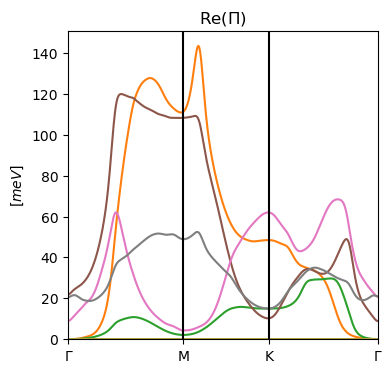

In [87]:
fig = plt.figure(figsize=(4,4))
for i in range(nph):
    # plt.plot(selfen_matrix[i][i].real,label=i)
    plt.plot(gaussian_filter1d(selfen_matrix[i][i].real.astype("float32"),10))
plt.xlim(0,nq)
# plt.xticks([0,nq*2/3,nq],["G","2/3M","M"])
# plt.axvline(nq*2/3,c='black',linestyle="--")
# plt.axhline(0,c='black',linestyle="--")
plt.xlim(0,nq)
plt.ylim(0)
for i in sym[1:-1]:
    plt.axvline(i,c='black')
plt.ylabel(r"$[{meV}^{2}]$")
plt.xticks(sym,["Γ","M","K","Γ"])
plt.title(r"Re($\Pi$)")
# plt.legend()
plt.ylabel(r"[$meV$]")
# plt.savefig("./output/Re.jpg",bbox_inches='tight')

# plt.title(r"g")
# plt.savefig("./output/re_pi_g.jpg",bbox_inches='tight')
plt.show()

In [79]:
selfen_matrix.shape

(9, 9, 1002)

In [80]:
selfen_matrix[2][1]

array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])

In [86]:
pwd

'/work/bansil/s.sevim/Work/typy'

In [87]:
with open("./output/selfen.dat", 'a') as file:
    for i in range(nph):
        for j in range(nph):
            if i<=j:
                for q in range(nq):
                    file.write(f"{q} {i} {j} {selfen_matrix[i][j][q].real} {selfen_matrix[i][j][q].imag} \n")

In [89]:
with open("./output/phonon.dat", 'a') as file:
    for i in range(nph):
        for q in range(nq):
            file.write(f"{q} {i} {fixed_ph[i][q]} \n")

In [90]:
sym

array([   0,  372,  650, 1001])

In [38]:
# for i in range(nph):
#     for j in range(nph):
#         if i<=j:
#             for q in range(nq):
#                 print(f"{q} {i} {j} {selfen_matrix[i][j][q].real} {selfen_matrix[i][j][q].imag}")

In [ ]:
npoint = 

In [ ]:
typy.path_create()